# Kruskal–Wallis Test in R (Jupyter Notebook)
This notebook runs through the Kruskal–Wallis test and post-hoc Dunn test, adapted from DataNovia’s "Kruskal‑Wallis test in R" tutorial.

Kruskal-Wallis test is a non-parametric alternative to the one-way ANOVA test. It extends the two-samples Wilcoxon test in the situation where there are more than two groups to compare. It’s recommended when the assumptions of one-way ANOVA test are not met.

In [17]:
# Install required packages (if not already installed)
if (!requireNamespace("rstatix", quietly = TRUE)) install.packages("rstatix")
if (!requireNamespace("ggpubr", quietly = TRUE)) install.packages("ggpubr")
if (!requireNamespace("FSA", quietly = TRUE)) install.packages("FSA")
if (!requireNamespace("PMCMRplus", quietly = TRUE)) install.packages("PMCMRplus")

# Load libraries
library(rstatix)
library(ggpubr)
library(dplyr)
library(PMCMRplus)
library(FSA)
library(tidyr)

### Data preparation

Here, we will use the built-in R data set named data. It contains the weight of plants obtained under a control and two different treatment conditions. In this example we will use groups A, B, C for the 3 treatments.

In [33]:
# Example dataset: three groups with different medians
set.seed(2025)
data <- data.frame(
  group = factor(rep(c("A", "B", "C"), each = 20)),
  weight = c(rnorm(20, 5, 1), rnorm(20, 7, 1), rnorm(20, 9, 1))
)
head(data)

,group,weight
,<fct>,<dbl>
1,A,5.620757
2,A,5.035641
3,A,5.773154
4,A,6.272489
5,A,5.370975
6,A,4.837146


In [34]:
#  Summary statistics by group (median & IQR)
data %>% group_by(group) %>% get_summary_stats(weight, type = "median_iqr")

group,variable,n,median,iqr
<fct>,<fct>,<dbl>,<dbl>,<dbl>
A,weight,20,5.203,0.949
B,weight,20,6.967,1.670
C,weight,20,9.244,1.404


### Visualization

Create a box plot of weight by group:

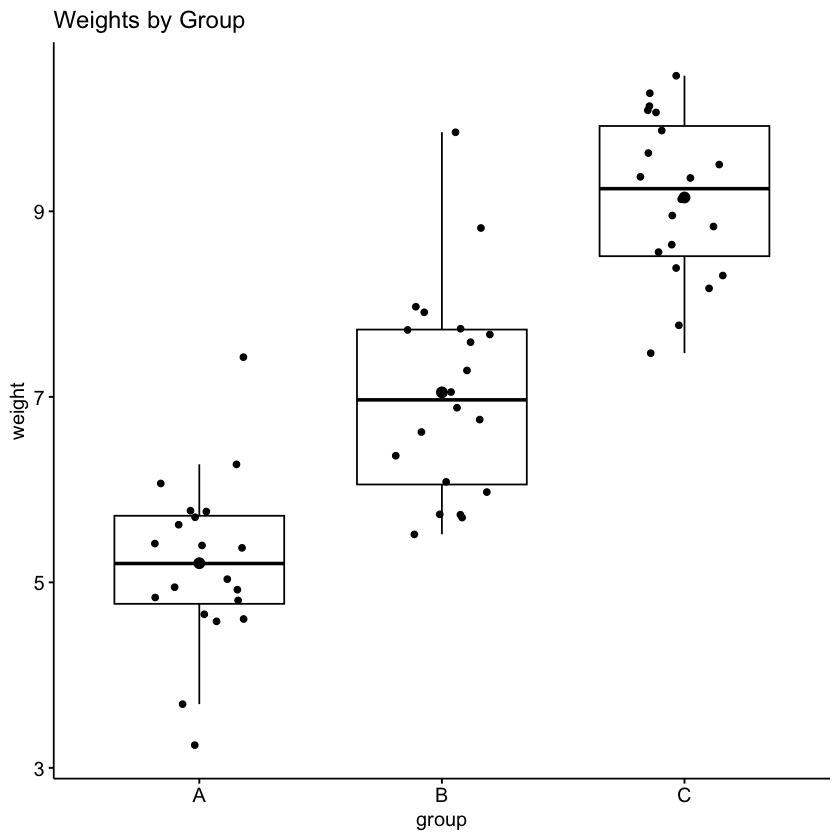

In [35]:
#  Visualize with boxplot + jitter
ggboxplot(data, x = "group", y = "weight", add = c("jitter", "mean"),
          palette = "jco", title = "Weights by Group")

### Computation

Question: We want to know if there is any significant difference between the average weights of plants in the 3 experimental conditions.

We’ll use the pipe-friendly kruskal_test() function [rstatix package], a wrapper around the R base function kruskal.test().

In [ ]:
#  Kruskal–Wallis test
kw_test <- data %>% kruskal_test(weight ~ group)
kw_test

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>
Kruskal-Wallis chi-squared,weight,60,44.5282,2,2.14e-10,Kruskal-Wallis


### Effect size

The eta squared, based on the H-statistic, can be used as the measure of the Kruskal-Wallis test effect size. It is calculated as follow : eta2[H] = (H - k + 1)/(n - k); where H is the value obtained in the Kruskal-Wallis test; k is the number of groups; n is the total number of observations (M. T. Tomczak and Tomczak 2014).

The eta-squared estimate assumes values from 0 to 1 and multiplied by 100 indicates the percentage of variance in the dependent variable explained by the independent variable.

The interpretation values commonly in published literature are: 0.01- < 0.06 (small effect), 0.06 - < 0.14 (moderate effect) and >= 0.14 (large effect).

In [37]:
# Effect size for Kruskal–Wallis (eta-squared)
data %>% kruskal_effsize(weight ~ group)

,.y.,n,effsize,method,magnitude
,<chr>,<int>,<dbl>,<chr>,<ord>
Kruskal-Wallis chi-squared,weight,60,0.7461087,eta2[H],large


### Multiple pairwise-comparisons

From the output of the Kruskal-Wallis test, we know that there is a significant difference between groups, but we don’t know which pairs of groups are different.

A significant Kruskal-Wallis test is generally followed up by Dunn’s test to identify which groups are different. It’s also possible to use the Wilcoxon’s test to calculate pairwise comparisons between group levels with corrections for multiple testing.

Compared to the Wilcoxon’s test, the Dunn’s test takes into account the rankings used by the Kruskal-Wallis test. It also does ties adjustments.


In [43]:
#  Post‑hoc Dunn test with Bonferroni correction
# Use rstatix version of Dunn test
pwc <- data %>% 
  dunn_test(weight ~ group, p.adjust.method = "bonferroni")

# View result
pwc

,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,weight,A,B,20,20,3.268340,1.081802e-03,3.245405e-03,**
2,weight,A,C,20,20,6.672484,2.515087e-11,7.545260e-11,****
3,weight,B,C,20,20,3.404144,6.637174e-04,1.991152e-03,**


p.adj.signif meaning

This column represents how strong the result is, based on the adjusted p-value (p.adj), after correcting for multiple comparisons (e.g., Bonferroni correction):

| `p.adj` value        | `p.adj.signif` | Meaning                        |
|----------------------|----------------|--------------------------------|
| `p.adj ≥ 0.05`       | `"ns"`         | Not significant                |
| `p.adj < 0.05`       | `"*"`          | Significant                    |
| `p.adj < 0.01`       | `"**"`         | Very significant               |
| `p.adj < 0.001`      | `"***"`        | Highly significant             |
| `p.adj < 0.0001`     | `"****"`       | Extremely significant (rare case) |

These thresholds are common in biological sciences, psychology, and social sciences.


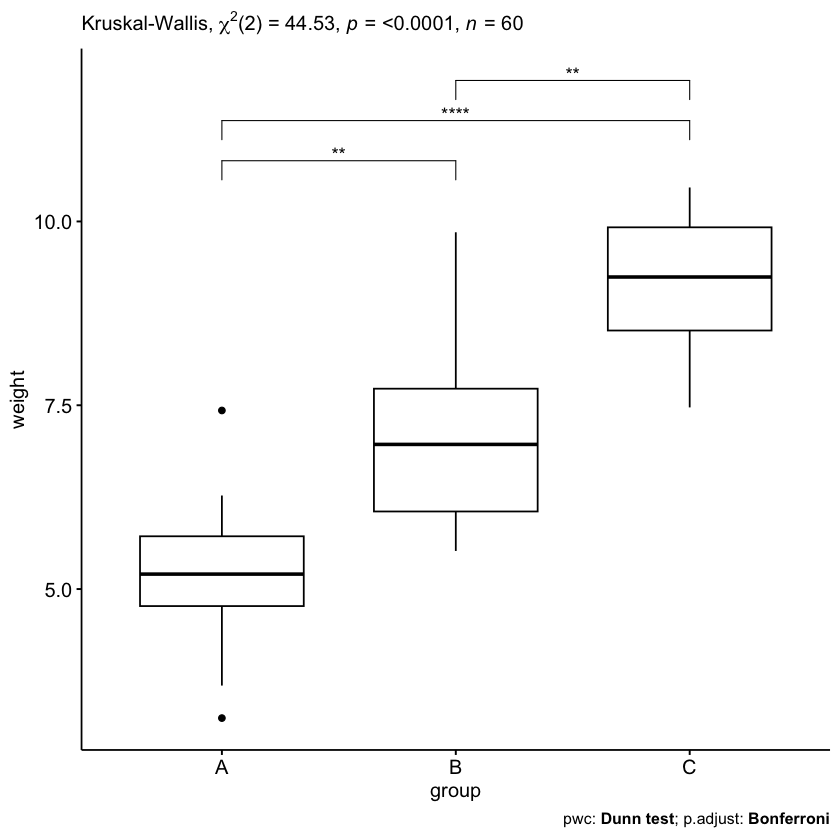

In [47]:
# Visualization: box plots with p-values
pwc <- pwc %>% add_xy_position(x = "group")
ggboxplot(data, x = "group", y = "weight") +
  stat_pvalue_manual(pwc, hide.ns = TRUE) +
  labs(
    subtitle = get_test_label(kw_test, detailed = TRUE),
    caption = get_pwc_label(pwc)
    )

##  Interpretation
- The **Kruskal–Wallis test** (`kruskal_test`) tells us *whether* there's at least one significant difference among groups.
- `kruskal_effsize()` outputs η², helping assess effect magnitude.
- The **Dunn test** pinpointed *which specific pairs* differ, with Bonferroni correction controlling for multiple testing.

Here is how to run and interpret the Kruskal–Wallis test (with post‑hoc Dunn) in Jupyter using R!